## 1. Preparando o dataset
<p>Com o passar dos últimos anos, serviços de streaming com um catálogo enorme tem se tornado o principal meio no qual a maioria das pessoas escutam sua música favorita. Mas ao mesmo tempo, este tanto de música disponível pode significar que os usuários se sintam um pouco sobrecarregados ao tentar encontrar novas músicas que se encaixam em seu gosto.</p>
<p>Por essa razão, os serviços de streaming encontraram meios para realizar recomendações personalizadas para seus usuários. Um dos métodos envolve a análise direta das informações "cruas" do aúdio de uma dada música, pontuando essas informações com uma variedade de métricas. Estarei examinando os dados compilados por um grupo de pesquisa chamado The Echo Nest. Meu objetivo é olhar para este dataset e com as informações sobre o aúdio, conseguir classificar corretamente as músicas entre 'Hip-Hop' ou 'Rock, isso tudo sem ouvir uma música sequer. Para isso, irei realizar uma limpeza nos dados, uma pequena análise exploratória para a visualização dos dados e por fim utilizar uma redução de dimensonalidade para realizar predições utilizando alguns algoritmos de Machine Learning mais simples, como Decision Trees e Logistic Regression.</p>
<p> Para começar, irei carregar a metadata sobre as músicas junto com as métricas de áudio daquela música compilada pela The Echo Nest. Uma música é mais do que seu título, artista e número de vezes escutada. Existe também um outro dataset que contém alguns 'features' da música, como <code>danceability</code> e <code>acousticness</code> em uma escala de -1 até 1. Isto existe em dois arquivos diferentes, um JSON e um CSV.</p>
<p>Começaremos criando dois pandas <code>DataFrames</code> destes arquivos assim poderei juntá-los para ter os 'features' e os rótulos (também frequentemente referido como <code>X</code> e <code>y</code> respectivamente) para a classificação final.</p>

In [2]:
import pandas as pd

# Leio a metadata das músicas com os rótulos de gênero
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')

# Leio as métricas das músicas com os features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json')

# Junto as colunas relevantes de tracks e echonest_metrics
echo_tracks = pd.merge(left = echonest_metrics, right = tracks[['track_id', 'genre_top']], on = 'track_id')

# Inspecionando o DataFrame resultante
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


## 2. Analisando relações entre as variáveis contínuas
<p> Tipicamente, queremos evitar utilizar variáveis que possuem uma grande correlação entre si - para evitar redundância nos features - por algumas razões: </p>
<ul>
<li>Para manter o modelo simples e melhorar a interpretação (com muitos features, corremos o risco de overfitting).</li>
<li>Quando nosso dataset é muito grande, utilizando menos features pode aumentar drasticamente a velocidade de computação.</li>
</ul>
<p>Para ter um sentido de quais variáveis estão fortemente correlacionadas, utilizei uma função built-in do pacote <code>pandas</code>.</p>

In [3]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


## 3. Padronização dos features
<p>Como mencionado anteriormente, pode ser útil simplicar os modelos e usar o tanto de features que forem necessárias para alcançar o melhor resultado. Visto que não foi observado nenhuma correlação forte entre os features, podemos utilizar uma forma comum de redução do número de features, conhecido como <strong>principal component analysis (PCA)</strong>. </p>
<p>É possível que a variânce entre os gêneros musicais possa ser explicado por apenas alguns features do dataset. PCA rotaciona os dados ao longo do eixo com maior variância, permitindo determinar a contribuição relativa de cada feature dos nossos dados em relação com as classes. Isto é, podemos perceber qual feature tem maior capacidade de explicar a classe (no caso, o gênero musical). </p>
<p>Entretanto, visto que o PCA utiliza a variância absoluta de um feature para rotacionar os dados, um feature com uma gama maior de valores, irá sobrecarregar e enviesar o algoritmo relativo aos outros features. Para escapar disso, necessita-se primeiro realizar uma normalização nos dados. Existem alguns métodos para fazer isso, mas um caminho comum é por meio da <em>padronização</em>, em que todos os features tem média = 0 e variância = 1 (o resultado é um z-score).</p>

In [4]:
# Definindo os features
features = echo_tracks.drop(['genre_top', 'track_id'], axis=1)

# Definindo os rótulos
labels = echo_tracks['genre_top']

# Importando StandardScaler
from sklearn.preprocessing import StandardScaler

# Padronizando os features e colocando o resultado em uma nova variável
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

## 4. Principal Component Analysis nos dados já padronizados
<p>Agora que foi realizado um pré-processamento nos dados, pode-se utilizar do PCA para determinar em quanto podemos reduzir a dimensionalidade dos dados. Podemos utilizar um <strong>scree-plot</strong> e <strong>cumulative explained ratio plots</strong> para achar o número de componentes para utilizar na análise futura.</p>
<p>Scree-plot mostra o número de componentes versus a variância explicada por cada componente, organizado em ordem decrescente da variância. Estes gráficos ajudam a ter um melhor sentido de quais componentes são melhores para explicar uma quantidade significativa da variância. Normalmente, utiliza-se a heurística do cotovelo para determinar qual o número de componentes iremos utilizar.</p>

Text(0.5, 0, 'Principal Component #')

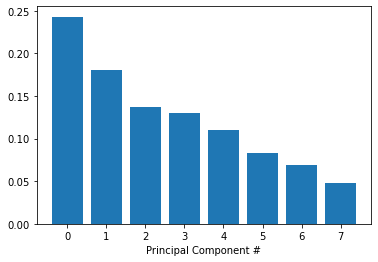

In [5]:
# Isso é apenas para os gráficos aparecerem no notebook
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Conseguindo a % da variância explicada utilizando todos os features no PCAs
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# Plotando a variância explicada em um gráfico de barras
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

## 5. Visualização adicional com PCA
<p>Infelizmente, não parece haver um bom ponto para utilizar-se da heurística do cotovelo neste gráfico, o que significa que não é tão fácil achar a dimensão intrínseca deste dataset.</p>
<p>Ao invés disso, podemos olhar para o <strong>cumulative explained variance plot</strong> para determinar quantos features são requeridos para explicar uma parte considerável do dataset, digamos, 85% (este valor é arbitrário). Uma vez determinado o número apropriado de componentes, podemos utilizar o PCA para reduzir a dimensionalidade e ficar com o número ideal de componentes.</p>

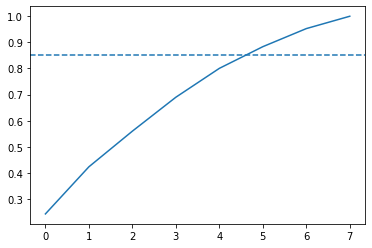

In [6]:
# Importando numpy
import numpy as np

# Calculando a variância explicada acumulada 
cum_exp_variance = np.cumsum(exp_variance)

# Plotando a variância explicada acumulada e desenhando uma linha pontilhada em 0.85
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

# Escolhendo o número de componentes que são mais ou menos os que explicam 85% da variância
n_components = 6

# Realizando o PCA com o número escolhido de componentes e projetando os dados para esses componentes
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

## 6. Treinando uma árvore de decisão para classificar o gênero musical
<p>Agora pode utilizar dos valores com dimensionalidade reduzida dos dados para classificar as músicas em gêneros. Para fazer isso, primeiro deve-se dividir o dataset em 'treino' e 'test' subsets, onde o 'treino' será utilizado para treinar o modelo e o 'teste' será utilizado para testar o modelo, e avaliar a perfemonace.</p>
<p>Aqui, utilizarei de um algoritmo simples conhecido como árvore de decisão. Árvores de decisão são classificadores baseado em regras, em que pega-se os features e segue-se por uma estrutura parecida como uma árvore de decisões binárias para finalmente classificar um ponto de dado em uma de duas ou mais categorias. São fáceis de usar e interpretar.</p>
<p>Aqui está um exemplo de árvore de decisão que demonstra um processo em que uma imagem passada (neste caso, o formato) será classificada baseada no número de lados que tem e se está rotacionada.</p>
<p><img src="https://assets.datacamp.com/production/project_449/img/simple_decision_tree.png" alt="Decision Tree Flow Chart Example" width="350px"></p>

In [7]:
# Importando train_test_split e Decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Dividindo os dados
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

# Treinando a árvore de decisão
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
# Prevendo os rótulos nos dados de teste
pred_labels_tree = tree.predict(test_features)

## 7. Comparando a Árvore de Decisão com a Regressão Logística
<p> Apesar de a perfomance da árvore ser decente, é uma má ideia assumir que é a melhor ferramenta para esse caso -- existe sempre a possibilidade de existirem outros modelos que vão performar melhor (No free lunch theorem). Sempre vale apena testes outros algoritmos e descobrir qual melhor se ajusta aos dados.</p>
<p> As vezes simplicidade é o melhor, então utilizarei uma <strong>regressão logística</strong>. Regressão lógistica utiliza-se de uma função chamada logística, em que calcula as chances de um determinado data point pertencer à uma determinada classe. Uma vez obtido os dois modelos, pode-se comparar a perfomance utilizando de algumas métricas de perfomance, como %Falsos positivos e %Falsos negativos. </p>

In [105]:
# Importando a Regressão Logística
from sklearn.linear_model import LogisticRegression

# Treinando a regressão logística e prevendo os rótulos do dataset de teste
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Criando um 'relatório de classificação' para os dois modelos
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.66      0.66      0.66       229
       Rock       0.92      0.92      0.92       972

avg / total       0.87      0.87      0.87      1201

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.75      0.57      0.65       229
       Rock       0.90      0.95      0.93       972

avg / total       0.87      0.88      0.87      1201



## 8. Balanceando os dados para obter uma melhor perfomance
<p>Os dois modelos foram similarmente bem, com uma precisão média de 0.87 cada. Contudo, olhando para o relatório gerado, podemos ver que as músicas de rock são bem melhor classificadas, mas as músicas de hip-hop são desproporcionalmente classifcadas como rock. </p>
<p>Por que isso poderia estar acontecendo? Bem, olhando para o número de pontos que temos para cada classe, podemos observador que tem-se muito mais pontos para a classe rock do que para a classe 'hip-hop', potencialmente isto pode estar diminuindo a capacidade do modelo de distinguir entre classes. Isso também diz que a precisão do modelo é baseada em sua habilidade em classificar músicas de rocks, o que é menos que o ideal.</p>
<p>Para ter isto em conta, podemos ponderar o valor de uma classificação correta em cada classe inversamente à ocorrência de pontos de dados para cada classe. Uma vez que uma classificação correcta para "Rock" não é mais importante do que uma classificação correcta para "Hip-Hop" (e vice-versa), só precisamos de ter em conta as diferenças em <em>tamanho da amostra</em> dos nossos pontos de dados ao ponderar as nossas classes, e não a importância relativa de cada classe. </p>

In [107]:
# Criando uma subamostra apenas para músicas de hip-hop e depois apenas para músicas de rock
hop_only = echo_tracks.loc[echo_tracks['genre_top']=='Hip-Hop']
rock_only =  echo_tracks.loc[echo_tracks['genre_top']=='Rock']

# Criando uma amostra de músicas de rock que possuí o mesmo número de músicas de hip-hop
rock_only = rock_only.sample(n=hop_only.shape[0], random_state=10)

# Concatenando os DataFrames rock_only e hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# Os features, labels e os componentes do PCA foram criados para o DataFrame balanceado
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefinindo o dataset de treino e de teste para os dados balanceados
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

## 9. Balanceando o Dataset melhorou o viés do modelo?
<p>Balanceamos o modelo, mas fazendo isso, pode ter-se removido informações cruciais para treinar os modelos. Veremos se balancear as classes melhorou a perfomance do modelo. </p>
<p>Note-se que já diminui-se o tamanho do dataset, portanto, prosseguirei sem nenhuma redução de dimensionalidade. Na prática, consideramos redução de dimensionalidade mais rigorosamente quando tratando com datasets vastamente grandes e quando a computação dos modelos torna-se expressivamente grande.</p>

In [109]:
# Treinando a Árvore de Decisão no dataset balanceado
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Treinando a Regressão Logística no dataset balanceado
logreg = LogisticRegression()
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.77      0.77      0.77       230
       Rock       0.76      0.76      0.76       225

avg / total       0.76      0.76      0.76       455

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.82      0.83      0.82       230
       Rock       0.82      0.81      0.82       225

avg / total       0.82      0.82      0.82       455



## 10. Utilizando de validação cruzada para avaliar os modelos
<p>Balanceando os dados removeu o viés proveniente da classe mais prevalente. Para ter um bom sentido em quão bem os modelos estão perfomando, pode-se aplicar o que é chamado de <strong>validação-cruzada</strong> (CV - CrossValidation). Este passo permite que compara-se os modelos de uma maneira mais rigorosa.</p>
<p>Visto que o modo em que nossos dados são dividos em 'treino' e 'teste podem impactar a perfomance do modelo, CV tenta dividir os dados de múltiplas maneiras, e testa o modelo em cada uma dessas divisões. Apesar de existirem muitos métodos de CV diferentes, todos com suas próprias vantagens e desvantagens, utilizarei o que é conhecido como <strong>K-fold</strong> CV aqui. K-Fold primeiro divide os dados entre K diferentes e de mesmo tamanho subsets. Então, ele iterativamente usa cada subset como o dataset de treino enquanto utiliza o resto dos dados para treinar o modelo. No final, podemos agregar os resultados de cada fold para uma pontuação final de perfomance.</p>

In [111]:
from sklearn.model_selection import KFold, cross_val_score

# Criando o KFold para Validação Cruzada
kf = KFold(10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# treinando os modelos utilizando validação cruzada
tree_score = cross_val_score(tree, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)

# Média da pontuação de cada um dos modelos treinados
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7241758241758242 Logistic Regression: 0.7752747252747252
